In [75]:
# Imports
import pandas as pd
import glob
import numpy as np
import matplotlib
from matplotlib import image
from matplotlib import pyplot as plt
import scipy.stats
import itertools
import netgraph
import datetime

In [76]:
# Constants
DATA_GLOB = '6G-Survey*.csv'
IMAGE_PATH = 'Map.php'
KM_PER_PX = 385/500 # Measured on the image
TEXT_TO_NUMERIC = {
    # fimilarity
    "Not familiar at all": 0,
    "Slightly familiar": 1,
    "Moderately familiar": 2,
    "Very familiar": 3,
    "Extremely familiar": 4,
    # ammount
    "Not at all": 0,
    "A little": 1,
    "A moderate amount": 2,
    "A lot": 3,
    "A great deal": 4,
    # bool
    "No": -1,
    "Maybe": 0,
    "Yes": 1,
    # agree
    "Strongly disagree": -2,
    "Somewhat disagree": -1,
    "Neutral": 0,
    "Somewhat agree": 1,
    "Strongly agree": 2,
    # time (unit is per day)
    "Never": 0,
    "Infrequently": 1 / 30,
    "Weekly": 1 / 7,
    "Daily": 1,
    "Multiple times a day": 2,
    # ages (just use average age, assume even distribution)
    "0-17": np.nan,
    "18-29": (18 + 29) / 2,
    "30-44": (30 + 44) / 2,
    "45-59": (45 + 59) / 2,
    "60+": (60 + 75) / 2,
    # gender
    # this isn't really a number but it needs to be for the
    # correlation math to work out. Ignores non male/female
    "Male": -1,
    "Female": 1,
    "Non-binary / third gender": np.nan,
    "Prefer not to say": np.nan,
}
CONCERNS = [
    "Privacy",
    "Initial cost of instillation",
    "Increased cost to use the system",
    "Reliability",
    "Dependence on internet connection",
    "Security risks",
    "Other, please specify:",
]
NUMERIC_QUESTIONS = [
    "Q12",  # How often do you use public transportation?
    "Q7",  # How familiar are you with 5G technology?
    "Q10",  # How much has 5G affected your quality of life?
    "Q11",  # How familiar are you with AI technology?
    "Q18",  # Would you prefer this over the current system?
    "Q19",  # This system would positively affect your quality of life.
    # "Q23",  # Would these considerations change any of your answers in the previous section?
    "Q25",  # Would you prefer this over the current system?
    "Q30",  # This system would positively affect your quality of life.
    "Q28",  # Select your age range.
    "Q29",  # Select your gender.
]

MULTIPLE_CHOICE_QUESTIONS = [
    
]

QUESTION_LOOKUP_TABLE = {
    "Q31": "What country are you from?",
    "Q12": "How often do you use public transportation?",
    "Q7": "How familiar are you with 5G technology?",
    "Q10": "How much has 5G affected your quality of life?",
    "Q11": "How familiar are you with AI technology?",
    "Q18": "Would you prefer this over the current system (Initial)?",
    "Q19": "This system would positively affect your quality of life (Initial).",
    "Q23": "Would these considerations change any of your answers in the previous section?",
    "Q25": "Would you prefer this over the current system (Final)?",
    "Q30": "This system would positively affect your quality of life (Final).",
    "Q28": "Select your age range.",
    "Q29": "Select your gender.",
    "Q21": "Initial concerns.",
    "Q27": "Final concerns.",
}

for question in ("Q21", "Q27"):
    for i, concern in enumerate(CONCERNS):
        MULTIPLE_CHOICE_QUESTIONS.append(f"{question}-{i}")
        QUESTION_LOOKUP_TABLE[f"{question}-{i}"] = f"{QUESTION_LOOKUP_TABLE[question][:-1]} - {concern}"

In [77]:
# Data pre-processing
data_path = glob.glob(DATA_GLOB)[0]
data = pd.read_csv(data_path)
# remove extra data at top
data = data.iloc[2:, :]

# convert string dates to datetime objects
data["StartDate"] = pd.to_datetime(data["StartDate"])
data["EndDate"] = pd.to_datetime(data["EndDate"])

# only use responses from Taiwan
data = data[data["Q31"] == "Taiwan"]

def add_concerns_columns(data: pd.DataFrame, question: str) -> pd.DataFrame:
    concerns_idx_table = (
        data[question]
        .apply(lambda x: None if pd.isna(x) else x)
        .apply(lambda x: x.split(",") if x is not None else [])
        .apply(lambda l: {CONCERNS.index(x) for x in l})
    )

    for i in range(len(CONCERNS)):
        data[f"{question}-{i}"] = [0] * len(data)

    for row_idx, concerns_idx in concerns_idx_table.items():
        for concern_idx in concerns_idx:
            data.loc[row_idx, f"{question}-{concern_idx}"] = 1
    
    return data

# change concerns questions to be boolean values in seperate columns
data = add_concerns_columns(data, "Q21")
data = add_concerns_columns(data, "Q27")

# convert everything possible to numeric
f = lambda x: TEXT_TO_NUMERIC[x] if x in TEXT_TO_NUMERIC else x
for col in NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS:
    data[col] = data[col].apply(f).astype(float)
    
data[["Q5_1_x", "Q5_1_y", "Q6_1_x", "Q6_1_y"]] = data[
    ["Q5_1_x", "Q5_1_y", "Q6_1_x", "Q6_1_y"]
].astype(float)


# data.head()

In [78]:
# Basic Data Stats
def print_data_stats(data):
    print(f"Total Responses: {len(data)}")

    train_station = data[
        (data["StartDate"]
        < pd.Timestamp(year=2024, month=4, day=5)) & (data["DistributionChannel"] == "qr")
    ]
    print(f"Responses from Train Station: {len(train_station)}")

    social_media = data[
        (data["StartDate"] < pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "anonymous")
    ]
    print(f"Responses from Social Media: {len(social_media)}")

    email_list = data[
        (data["StartDate"] > pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "anonymous")
    ]
    print(f"Responses from Email List: {len(email_list)}")

    scu = data[
        (data["StartDate"] > pd.Timestamp(year=2024, month=4, day=5))
        & (data["DistributionChannel"] == "qr")
    ]
    print(f"Responses from SCU: {len(scu)}")

# print_data_stats(data)

In [79]:
# Map
def map_locations(data):
    home = data[["Q5_1_x", "Q5_1_y"]]
    work = data[["Q6_1_x", "Q6_1_y"]]

    home_np = home.to_numpy()
    work_np = work.to_numpy()
    commute_distances_km = np.linalg.norm(home_np - work_np, axis=1) * KM_PER_PX

    data["commute_distances_km"] = commute_distances_km

    map = image.imread(IMAGE_PATH)

    plt.imshow(map)
    plt.scatter(home["Q5_1_x"], home["Q5_1_y"], c="red", label="Home", alpha=0.5, s=20)
    plt.scatter(work["Q6_1_x"], work["Q6_1_y"], c="blue", label="Work", alpha=0.5, s=20)
    # legend off to the side
    plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.9))
    # disable axis
    plt.axis("off")
    plt.show()
    
# map_locations(data)

In [80]:
# Finding correlations in the data
def print_correlations(data):
    data_pairs = itertools.combinations(data[NUMERIC_QUESTIONS + MULTIPLE_CHOICE_QUESTIONS], 2)

    # checks to see if whole column is the same value
    def is_constant(s):
        a = s.to_numpy()  # s.values (pandas<0.24)
        return (a[0] == a).all()


    for l, r in data_pairs:
        # ignore correlations between multiple choice questions,
        # these are better shown in a correlation matrix
        if l in MULTIPLE_CHOICE_QUESTIONS and r in MULTIPLE_CHOICE_QUESTIONS:
            continue
        
        cols = data[[l, r]].dropna(axis=0, how='any')

        # continue on constant columns
        if is_constant(cols[l]) or is_constant(cols[r]):
            continue

        stats = scipy.stats.pearsonr(cols[l], cols[r])
        if stats.pvalue < 0.05 and stats.pvalue != 0:
            print(
                f'"{QUESTION_LOOKUP_TABLE[l]}" strongly correlates with "{QUESTION_LOOKUP_TABLE[r]}":',
                end="",
            )
            print(f"  correlation={stats.statistic:.3f}, p={stats.pvalue:.4f}", end="")
            print(f"  N={len(cols)}")
            
# print_correlations(data)

In [81]:
def graph_concerns(data):
    Q21 = data[[f"Q21-{i}" for i in range(len(CONCERNS))][:-1]]
    Q21 = Q21.corr().to_numpy()

    Q21[np.triu_indices(Q21.shape[0])] = np.nan

    label = "Key:\n" +"\n".join([f"- {i}. {concern}" for i, concern in enumerate(CONCERNS)][:-1])

    plt.matshow(Q21)
    plt.colorbar()
    plt.title("Concerns Questions Correleation")
    plt.text(-0.5,8,label)
    plt.show()

    # POSITIVE_CONNECTION_THRESHOLD = 0.3
    # connections = (
    #     np.logical_or(Q21 > POSITIVE_CONNECTION_THRESHOLD, np.eye(Q21.shape[0]))
    # ).nonzero()
    # connections = np.transpose(connections)
    # plot_instance = netgraph.Graph(connections)
    # plt.show()

# graph_concerns(data)

Data stats:
Total Responses: 61
Responses from Train Station: 11
Responses from Social Media: 26
Responses from Email List: 3
Responses from SCU: 21




Data map:


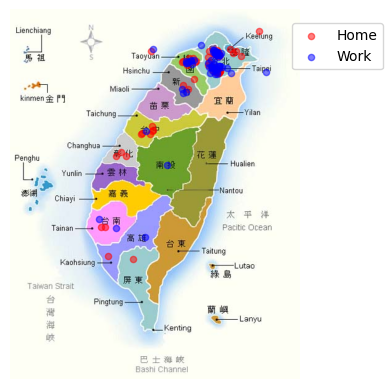





Data correlations:
"How often do you use public transportation?" strongly correlates with "Select your age range.":  correlation=-0.273, p=0.0349  N=60
"How often do you use public transportation?" strongly correlates with "Initial concerns - Reliability":  correlation=0.267, p=0.0389  N=60
"How familiar are you with 5G technology?" strongly correlates with "How much has 5G affected your quality of life?":  correlation=0.293, p=0.0454  N=47
"How familiar are you with 5G technology?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.533, p=0.0000  N=59
"How much has 5G affected your quality of life?" strongly correlates with "How familiar are you with AI technology?":  correlation=0.468, p=0.0010  N=46
"How familiar are you with AI technology?" strongly correlates with "This system would positively affect your quality of life (Initial).":  correlation=0.321, p=0.0150  N=57
"Would you prefer this over the current system (Initial)?" strongly correlate

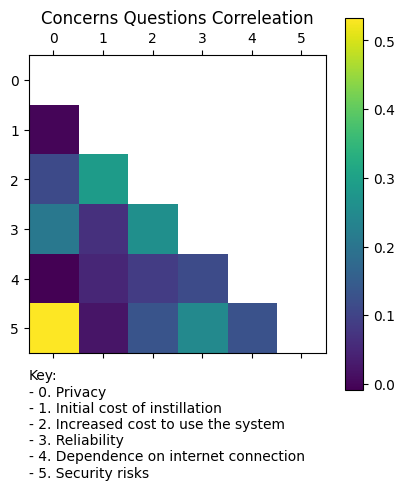

In [82]:
def full_analysis(data):
    print("Data stats:")
    print_data_stats(data)

    print("\n"*3)
    print("Data map:")
    map_locations(data)

    print("\n"*3)
    print("Data correlations:")
    print_correlations(data)

    print("\n"*3)
    print("Concerns graph:")
    graph_concerns(data)
    
full_analysis(data)